# 挂载google drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive 
!google-drive-ocamlfuse drive

In [0]:
!pwd
import os
os.chdir('./drive/COMP5318/comp5318 assignment2/')
!pwd
!ls

/content
/content/drive/COMP5318/comp5318 assignment2
comp5318_assignment2_color_CNN.ipynb  dataset
comp5318_assignment2_color_LR.ipynb   drive


#assignment

##预处理1

In [0]:
from __future__ import print_function
from sklearn.metrics import classification_report, confusion_matrix
from scipy.io import loadmat as load
from sklearn.preprocessing import OneHotEncoder
import os
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

读取文件

In [0]:
train= load('./dataset/train_32x32.mat') # data is train['X'], label is train['y']
validation= load('./dataset/test_32x32.mat')

分开数据和label

In [0]:
# 分割train_data 成 10个子样本
def seprate_data(data, K, type='data'):
    if type == 'data':
        number_of_training_data = data.shape[3]
        data = data.transpose((3, 0, 1, 2))

    else:
        number_of_training_data = data.shape[0]
        data = data.flatten()
        data[data == 10] = 0

    return data


train_data_t = seprate_data(train['X'], 10, type='data')
print('train_data_t的完整结构', train_data_t.shape)
train_labels_t = seprate_data(train['y'], 10, type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t的完整结构', np.shape(train_labels_t))

validation_data_t = seprate_data(validation['X'], 10, type='data')
print('train_data_t的完整结构', validation_data_t.shape)
validation_labels_t = seprate_data(validation['y'], 10, type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t的完整结构', np.shape(validation_labels_t))

train_data_t的完整结构 (73257, 32, 32, 3)
train_labels_t的完整结构 (73257,)
train_data_t的完整结构 (26032, 32, 32, 3)
train_labels_t的完整结构 (26032,)


修改label

In [0]:
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(train_labels_t.reshape(-1, 1))
validation_enc = OneHotEncoder().fit(validation_labels_t.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
train_labels_t = enc.transform(train_labels_t.reshape(-1, 1)).toarray()

validation_labels_t = validation_enc.transform(validation_labels_t.reshape(-1, 1)).toarray()

变成灰度

In [0]:
image_size = 32  
pixel_depth = 255.0  

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)

    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(np.array(train_data_t))[:,:,:,0]

validation_data_c = im2gray(np.array(validation_data_t))[:,:,:,0]

print('train_data_c的完整结构',train_data_c.shape)

train_data_c的完整结构 (73257, 32, 32)


正则化

In [0]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""

    imsize = image.shape[0]
    mean = np.mean(image, axis=(1, 2), dtype=float)
    std = np.std(image, axis=(1, 2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)

    for i in np.arange(imsize):
        image_GCN[i, :, :] = (image[i, :, :] - mean[i]) / std[i]

    return image_GCN


train_data_GCN = GCN(train_data_c)

validation_data_GCN = GCN(validation_data_c)

print(train_data_GCN.shape, np.shape(train_labels_t))

(73257, 32, 32) (73257, 10)


##创建训练集和测试集

In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

train_data_GCN,train_labels,test_data_GCN,test_labels=train_test_split_10(train_data_GCN, train_labels_t,0)
print(np.shape(train_data_GCN))
print(np.shape(train_labels))
print(np.shape(test_data_GCN))
print(np.shape(test_labels))
print(np.shape(validation_data_GCN))
print(np.shape(validation_labels_t))

(65932, 32, 32)
(65932, 10)
(7325, 32, 32)
(7325, 10)
(26032, 32, 32)
(26032, 10)


##CNN分类器

In [0]:
img_size = train_data_GCN.shape[1]

num_channels = 1

num_classes = train_labels.shape[1]

预处理

In [0]:

train_mean = np.mean(train_data_GCN, axis=0)


train_std = np.std(train_data_GCN, axis=0)


train_data_GCN = (train_data_GCN - train_mean) / train_std
test_data_GCN = (test_data_GCN - train_mean)  / train_std
validation_data_GCN = (validation_data_GCN - train_mean)  / train_std

显示方法

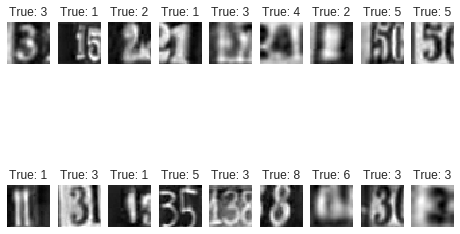

In [0]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    fig, axes = plt.subplots(nrows, ncols)
    rs = np.random.choice(images.shape[0], nrows * ncols)
    for i, ax in zip(rs, axes.flat):
      if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
            else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

        ax.imshow(images[i, :, :, 0], cmap='binary')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

temp=train_data_GCN.reshape(train_data_GCN.shape[0],train_data_GCN.shape[1],train_data_GCN.shape[2],1)
plot_images(temp, 2, 9, train_labels)

1.定义卷基层weight
2.定义全链接曾weight
3.定义bias

In [0]:
def conv_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

卷基层 输入的数据,输入的数据深度, 卷机使用的

In [0]:
def conv_layer(input,  
               layer_name,  
               num_input_channels,  
               filter_size,  
               num_filters, 
               pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = conv_weight_variable(layer_name, shape=shape)
    biases = bias_variable(shape=[num_filters])
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    layer = tf.nn.relu(layer)
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    return layer, weights


In [0]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [0]:
def fc_layer(input,        
             layer_name,   
             num_inputs,   
             num_outputs,  
             relu=True):   

    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])
    layer = tf.matmul(input, weights) + biases
    if relu:
        layer = tf.nn.relu(layer)

    return layer

In [0]:
# Convolutional Layer 1.
filter_size1 = 5          
num_filters1 = 32         
# Convolutional Layer 2.
filter_size2 = 5          
num_filters2 = 64         
# Fully-connected layer.
fc_size = 256 

In [0]:
# Number of training samples in each iteration
batch_size = 64
dropout = 0.5
total_iterations = 0

In [0]:
def train(train_data_GCN,train_labels,test_data_GCN,test_labels,validation_data_GCN,validation_labels_t,K):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')
    train_data_GCN = train_data_GCN.reshape(train_data_GCN.shape[0], train_data_GCN.shape[1], train_data_GCN.shape[2],
                                            1)
    test_data_GCN = test_data_GCN.reshape(test_data_GCN.shape[0], test_data_GCN.shape[1], test_data_GCN.shape[2], 1)
    validation_data_GCN = validation_data_GCN.reshape(validation_data_GCN.shape[0], validation_data_GCN.shape[1],
                                                      validation_data_GCN.shape[2], 1)
    print(np.shape(train_data_GCN))

    y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

    y_true_cls = tf.argmax(y_true, dimension=1)

    keep_prob = tf.placeholder(tf.float32)

    #
    conv_1, w_c1 = conv_layer(input=x,
                              layer_name="conv_1",
                              num_input_channels=num_channels,
                              filter_size=filter_size1,
                              num_filters=num_filters1, pooling=True)

    conv_1
    #
    conv_2, w_c2 = conv_layer(input=conv_1,
                              layer_name="conv_2",
                              num_input_channels=num_filters1,
                              filter_size=filter_size2,
                              num_filters=num_filters2,
                              pooling=True)

    dropout = tf.nn.dropout(conv_2, keep_prob)

    dropout
    #
    layer_flat, num_features = flatten_layer(dropout)

    layer_flat
    #

    fc_1 = fc_layer(input=layer_flat,
                    layer_name="fc_1",
                    num_inputs=num_features,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=num_classes,
                    relu=False)

    fc_2
    #

    y_pred = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

    global_step = tf.Variable(0)

    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    saver = tf.train.Saver()
    save_dir = "./modelfor_" + str(K) + "/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, 'svhn_single_greyscale')
    with tf.Session() as sess:

        sess.run(tf.initialize_all_variables())

        #total_iterations = 0
        num_iterations = 50000
        display_step = 5000
        X_train = train_data_GCN
        y_train = train_labels
        X_test = test_data_GCN
        y_test = test_labels
        X_val = validation_data_GCN
        y_val = validation_labels_t

        global total_iterations
        
        start_time = time.time()
        for step in range(num_iterations):

            offset = (step * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :, :, :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            #print(type(batch_data))
            #print(type(batch_labels))
            #print(type(dropout))
            dropout=0.5
            feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}
            sess.run(optimizer, feed_dict=feed_dict_train)

            if step % display_step == 0:
                batch_acc = sess.run(accuracy, feed_dict=feed_dict_train)
                print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
                validation_acc = sess.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.0})
                print("Validation accuracy: %.4f" % validation_acc)

        total_iterations += num_iterations
        time_diff = time.time() - start_time
        test_accuracy = sess.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})

        print("Test accuracy: %.4f" % test_accuracy)
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
        saver.save(sess=sess, save_path=save_path)

        test_pred = sess.run(y_pred_cls, {x: validation_data_GCN, y_true: validation_labels_t, keep_prob: 1.0})
    return test_pred
     

##执行

In [1]:
test_pred=train(train_data_GCN,train_labels,test_data_GCN,test_labels,validation_data_GCN,validation_labels_t,0)


NameError: ignored

##结果

[5 2 1 ... 7 6 7]


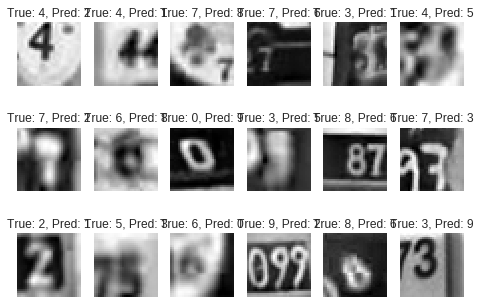

In [0]:
incorrect = test_pred != np.argmax(validation_labels_t, axis=1)
print(test_pred)
temp = validation_data_GCN.reshape(validation_data_GCN.shape[0],validation_data_GCN.shape[1],validation_data_GCN.shape[2],1)


# Select the incorrectly classified examples
images = temp[incorrect]
cls_true = validation_labels_t[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

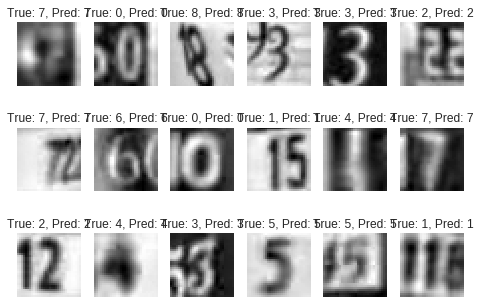

In [0]:
correct = np.invert(incorrect)

# Select the correctly classified examples
images = temp[correct]
cls_true = validation_labels_t[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred)

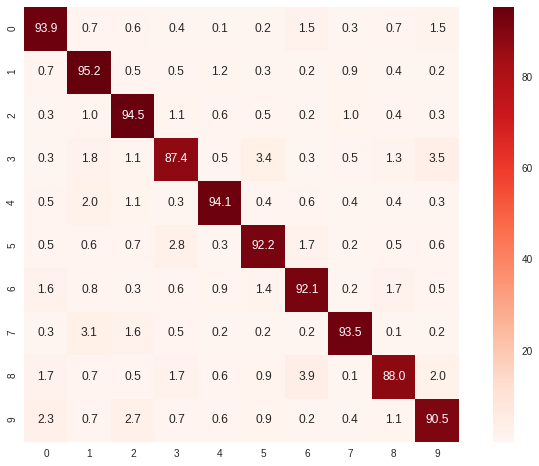

In [0]:
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(validation_labels_t, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);